In [35]:
import numpy as np
from numpy.matlib import repmat

In [36]:
pip install keras

In [37]:
pip install tensor flow

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [39]:
from keras.datasets import mnist

In [40]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [41]:
import numpy as np
from numpy.matlib import repmat
from numpy.linalg import inv,pinv
import matplotlib
import matplotlib.pyplot as plt
import sys
from scipy.io import loadmat
import time

def gaussian(self, X):
  means = {}
  covariance = {}
  priors = {}  # p(Ck)
  for class_id, values in X.items():
    proj = np.dot(values, self.W)
    means[class_id] = np.mean(proj, axis=0)
    covariance[class_id] = np.cov(proj, rowvar=False)
    # estimate the priors using fractions of the training set data points in each of the classes.
    priors[class_id] = values.shape[0] / self.N
  return means, covariance, priors


def gaussian_distribution(self, x, u, cov):
  scalar = (1. / ((2 * np.pi) ** (x.shape[0] / 2.))) * (1 / np.sqrt(np.linalg.det(cov)))
  x_sub_u = np.subtract(x, u)
  return scalar * np.exp(-np.dot(np.dot(x_sub_u, inv(cov)), x_sub_u.T) / 2.)

In [42]:
def l2distance(x, y=None):
    """

    This function computes the euclidean distance.
    
    """
    if y is None:
        n, d = x.shape
        sum1 = np.sum(np.power(x, 2), axis=1).reshape(-1,1)
        A1 = -2 * np.dot(x, x.T) + repmat(sum1, 1, n)
        A = A1 + repmat(sum1.T, n, 1)
        np.fill_diagonal(A, 0)
        A = np.sqrt(np.maximum(A, 0))
    else:
        n, d = x.shape
        m, _ = y.shape
        sum1 = np.sum(np.power(x, 2), axis=1).reshape(-1,1)
        s2 = np.sum(np.power(y, 2), axis=1).reshape(1,-1)
        A1 = -2 * np.dot(x, y.T) + repmat(sum1, 1, m)
        A = A1 + repmat(s2, n, 1)
        A = np.sqrt(np.maximum(A, 0))
    return A

In [43]:
def toydata(offset,m):
    """    
    With this function we are constructing a binary data set. The classes are distributed by a standard guassian distribution.

    """
    
    mmod = int(np.ceil(m/2))
    x = np.random.randn(m, 2)# x N*2
    x[mmod:, :] += offset  
    
    y = np.ones(m)
    y[mmod:] *= 2# y=1 or 2
    
    perm = np.random.permutation(m)
    return x[perm, :], y[perm]

In [44]:
def computeybar(xTe, offset):
    """
    
    This function computes the label y-bar(a n by 1 vector of expected labels) for a set of inputs x which is generated from two standard ND.

    """
    y,temp = xTe.shape
    ybar = np.zeros(y)
    
    comp = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)
    
    probXY1=comp(xTe,0,1)
    probXxY1=probXY1[:,0]*probXY1[:,1]
    probXY2=comp(xTe,offset,1)
    probXxY2=probXY2[:,0]*probXY2[:,1]
    
    probXX=probXxY1*0.5+probXxY2*0.5
    
    
    probY1xX=probXxY1*0.5/probXX
    probY2xX=probXxY2*0.5/probXX
    
    ybar=probY1xX+2*probY2xX
    
    return ybar

71
The Error in Bayes classifier is : 7.1%.


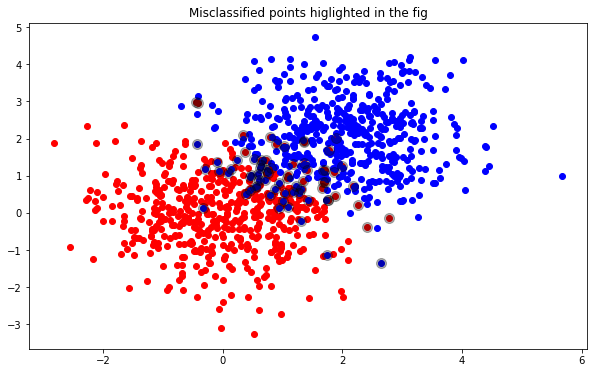

In [45]:
offset = 2
xTe, yTe = toydata(offset, 1000)

# computing the bayes error
ybar = computeybar(xTe, offset)
pred = np.round(ybar)
err = pred != yTe
e = err.sum() / len(yTe) * 100
print(err.sum())
print('The Error in Bayes classifier is : %.1f%%.' % e)

# plotting the data
y1 = yTe == 1
y2 = yTe == 2
plt.figure(figsize=(10,6))
plt.scatter(xTe[y1, 0], xTe[y1, 1], c='r', marker='o')
plt.scatter(xTe[y2, 0], xTe[y2, 1], c='b', marker='o')
plt.scatter(xTe[err, 0], xTe[err, 1], c='k', s=100, alpha=0.3)
plt.title("Misclassified points higlighted in the fig")
plt.show()

In [46]:
def kregression(xTr,yTr,sigma=0.1,lmbda=0.01):
    """
    
    kregression is a helper function which will give the hD value to us. This is called kernelized ridge regression.
    We will later call this function in the computehbar function. Sigma is the kernel width and lambda is regularization constant
    
    """
    kernel = lambda x, z: np.power(1+(np.power(l2distance(x,z),2) / (2 * np.power(sigma,2))),-4)
    ridge = lambda K, lmbda2: K + lmbda * np.eye(K.shape[0], K.shape[1])
    b = np.linalg.solve(ridge(kernel(xTr, xTr), lmbda), yTr)
    
    fun = lambda Xt: np.dot(kernel(Xt, xTr), b)
    return fun

In [47]:
def computehbar(xTe, sigma, lmbda, subsampleNum, numModels, offset):
    """
    We will approximate the bias by traning many hD and then averaging their predictions

    """
    n = xTe.shape[0]
    hbar = np.zeros(n)
    for num in range(numModels):
        xTr,yTr=toydata(offset,subsampleNum)
        m=kregression(xTr,yTr,sigma,lmbda)
        hbar+=m(xTe)    
    hbar /= numModels
    return hbar

In [48]:
def computevariance(xTe, sigma, lmbda, hbar, subsampleNum, numModels, offset):
    """
    
    Now we will compute the variance of classifiers which was trained on datasets with the predefined offset value and 
    Kernel regression. The prediction of the average classifier is stored in hbar.
    
    """
    n = xTe.shape[0]
    var = np.zeros(n)
      
    for num in range(numModels):
        xTr,yTr=toydata(offset,subsampleNum)
        m=kregression(xTr,yTr,sigma,lmbda)
        var+=(m(xTe)-hbar)**2    
    
    var = np.mean(var)/numModels
    return var

In [49]:
# The training set size N
subsampleNum = 10
# Defining the value of big data set
bigData = 10000
# number of models to average over
numModels = 100
# Regularization Constant
lmbdas = np.arange(-6, 0+0.5, 0.5)
# Kernel Width
sigma = 4

lenLambdas = len(lmbdas)
lisbias = np.zeros(lenLambdas)
lenvariance = np.zeros(lenLambdas)
lisTotal = np.zeros(lenLambdas)
lisnoise = np.zeros(lenLambdas)
lsum = np.zeros(lenLambdas)

# Different regularization constant classifiers
for l in range(lenLambdas):
    lmbda = 2 ** lmbdas[l]
    # use this data set as an approximation of the true test set
    xTe,yTe = toydata(offset,bigData)
    
    total = 0
    for num in range(numModels):
        xTr2,yTr2 = toydata(offset,subsampleNum)
        fs = kregression(xTr2,yTr2,sigma,lmbda)
        total += np.mean((fs(xTe) - yTe) ** 2)
    total /= numModels
    
    # Calculate the Noise
    ybar = computeybar(xTe, offset)
    noise = np.mean((yTe-ybar) ** 2)
    
    # Calculate the Bias
    hbar = computehbar(xTe,sigma, lmbda, subsampleNum, numModels, offset)
    bias = np.mean((hbar-ybar) ** 2)
    
    # Calculate the VARIANCE
    variance = computevariance(xTe,sigma,lmbda,hbar, subsampleNum, numModels, offset)
    
    lisbias[l] = bias
    lenvariance[l] = variance
    lisTotal[l] = total
    lisnoise[l] = noise
    lsum[l] = lisbias[l]+lenvariance[l]+lisnoise[l]
    print('Regularization λ is = 2^%2.1f : Bias is : %2.4f Variance is : %2.4f Noise is : %2.4f Bias + Variance + Noise : %2.4f Test error : %2.4f'
          % (lmbdas[l],lisbias[l],lenvariance[l],lisnoise[l],lsum[l],lisTotal[l]))

Regularization λ is = 2^-6.0 : Bias is : 0.0281 Variance is : 0.0855 Noise is : 0.0564 Bias + Variance + Noise : 0.1701 Test error : 0.1678
Regularization λ is = 2^-5.5 : Bias is : 0.0337 Variance is : 0.0767 Noise is : 0.0582 Bias + Variance + Noise : 0.1687 Test error : 0.1511
Regularization λ is = 2^-5.0 : Bias is : 0.0297 Variance is : 0.0617 Noise is : 0.0578 Bias + Variance + Noise : 0.1492 Test error : 0.1563
Regularization λ is = 2^-4.5 : Bias is : 0.0355 Variance is : 0.0517 Noise is : 0.0579 Bias + Variance + Noise : 0.1451 Test error : 0.1423
Regularization λ is = 2^-4.0 : Bias is : 0.0347 Variance is : 0.0465 Noise is : 0.0577 Bias + Variance + Noise : 0.1389 Test error : 0.1423
Regularization λ is = 2^-3.5 : Bias is : 0.0388 Variance is : 0.0425 Noise is : 0.0596 Bias + Variance + Noise : 0.1408 Test error : 0.1432
Regularization λ is = 2^-3.0 : Bias is : 0.0471 Variance is : 0.0358 Noise is : 0.0525 Bias + Variance + Noise : 0.1354 Test error : 0.1409
Regularization λ is 

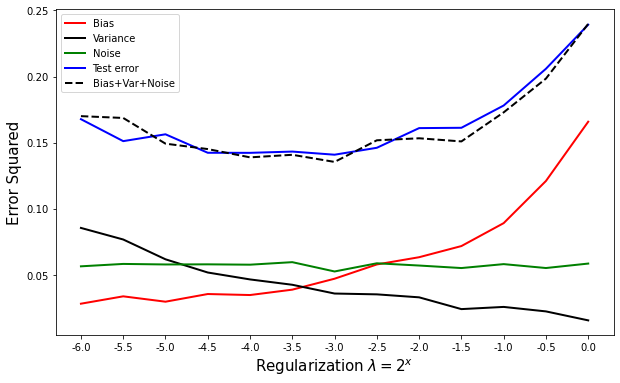

In [50]:
# plotting the results
plt.figure(figsize=(10,6))
plt.plot(lisbias[:lenLambdas],c='r',linestyle='-',linewidth=2)
plt.plot(lenvariance[:lenLambdas],c='k', linestyle='-',linewidth=2)
plt.plot(lisnoise[:lenLambdas],c='g', linestyle='-',linewidth=2)
plt.plot(lisTotal[:lenLambdas],c='b', linestyle='-',linewidth=2)
plt.plot(lsum[:lenLambdas],c='k', linestyle='--',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"]);
plt.xlabel("Regularization $\lambda=2^x$",fontsize=15);
plt.ylabel("Error Squared",fontsize=15);
plt.xticks([i for i in range(lenLambdas)],lmbdas);

In [ ]:
# Reference: https://towardsdatascience.com/the-bias-variance-trade-off-explained-practically-in-python-48cf29d9e900